# Capstone Project- Fake News Identification

####  Table Of Contents
- [1.0 Introduction](#introduction)
- [2.0 Exploratory Data Analysis](#EDA)



<a id='introduction'></a>
### Introduction

The aim of this project is to identify fake news from real news. The subject of fake news became popular after US presidential election but after that many media companies are using fake news articles for their own benefits. These fake news can affect stock market, politics, religion beliefs and many other things. This project is aimed at classifying news articles into 3 categories: 1. High factual, 2. Mixed factual, 3. Low factual

For this classification I have scraped almost 34,600 articles from past 30 days from different websites. For scraping these articles I used Webhoseio API. And classification of those articles are done based on  www.mediabiasfactcheck.com

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import shuffle

from sklearn.pipeline import Pipeline

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import HashingVectorizer

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix

from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [2]:
data_file = './data/news_data.csv'

In [3]:
## Load data into dataframe
news_df = pd.read_csv(data_file)

In [4]:
news_df.head()

,Unnamed: 0,author,country,crawled,domain_rank,facebook_comments,facebook_likes,language,main_image,participants_count,published,rating,site,site_categories,site_type,text,title,url,factual_reporting
0,0,Javier Moreno,US,2019-04-11T07:20:39.028+03:00,137.0,319,382,english,https://img.buzzfeed.com/buzzfeed-static/stati...,1,2019-04-11T12:14:00.000+03:00,NaN,www.buzzfeed.com,"['media', 'homework_study_tips', 'education']",blogs,Questions are coming. HBO Correct Incorrect Co...,"Which ""Game Of Thrones"" Group Do You Really Be...",https://www.buzzfeed.com/javiermoreno/game-of-...,Mixed
1,1,Political Reporter Jackson Gothe-Snape,AU,2019-04-11T07:25:13.024+03:00,1455.0,45,43,english,https://www.abc.net.au/news/image/9226414-16x9...,1,2019-04-11T03:00:00.000+03:00,NaN,www.abc.net.au,"['television', 'music', 'entertainment']",news,Australians are increasingly suspicious of gov...,Election to focus on economy but voters losing...,https://www.abc.net.au/news/2019-04-11/federal...,High
2,2,sports.yahoo.com,US,2019-04-11T07:35:44.051+03:00,137.0,0,0,english,https://img.buzzfeed.com/buzzfeed-static/stati...,1,2019-04-11T03:00:00.000+03:00,NaN,www.buzzfeed.com,"['media', 'homework_study_tips', 'education']",news,Share On facebook Share On facebook Compartilh...,Responda estas perguntas sobre sexo e adivinha...,https://www.buzzfeed.com/br/luisdelvalle/respo...,Mixed
3,3,Yoonjung Seo,US,2019-04-11T07:36:28.007+03:00,81.0,3031,24808,english,https://cdn.cnn.com/cnnnext/dam/assets/1904101...,1,2019-04-11T12:19:00.000+03:00,NaN,edition.cnn.com,['media'],news,Seoul (CNN) South Korea's 66-year abortion ban...,Will South Korea legalize abortion after 50-ye...,https://edition.cnn.com/2019/04/11/health/sout...,Mixed
4,4,Caroline Kelly,US,2019-04-11T07:36:45.001+03:00,81.0,5701,20690,english,https://cdn.cnn.com/cnnnext/dam/assets/1603211...,1,2019-04-11T12:24:00.000+03:00,NaN,edition.cnn.com,['media'],news,Washington (CNN) President Donald Trump's olde...,"Investigation into Maryanne Trump Barry, Presi...",https://edition.cnn.com/2019/04/11/politics/ma...,Mixed


In [5]:
news_df.shape

(34680, 19)

<a id='EDA'></a>

## Exploratory Data Analysis

In [6]:
news_df.isnull().sum()

Unnamed: 0                0
author                 7624
country                 426
crawled                   0
domain_rank            1768
facebook_comments         0
facebook_likes            0
language                  0
main_image             1183
participants_count        0
published                 0
rating                34680
site                      0
site_categories           0
site_type                 0
text                      0
title                  3005
url                       0
factual_reporting         0
dtype: int64

### It seems that unnamed is an extra column so we need to drop it and also rating value of each article is not available.So we need to drop both of them

In [7]:
news_df.drop(['Unnamed: 0','rating'],axis=1,inplace=True)

In [8]:
news_df.shape

(34680, 17)

In [9]:
#finding the columns having null values and data type is object
null_columns_with_dt_object = [col for col in news_df.columns if (news_df[col].isnull().sum()>0) & (news_df[col].dtype == np.object)]
                #(news_df[col].dtype == np.object)] 
null_columns_with_dt_object

['author', 'country', 'main_image', 'title']

In [10]:
#replacing the null values
for each_column in null_columns_with_dt_object:
    news_df[each_column].fillna('NA',inplace=True)
    

In [11]:
#replacing the null values for domain rank
news_df['domain_rank'].fillna(0,inplace=True)


In [12]:
#changing the country code to their corresponsing name
country_encoded_dict = {'US' :  'United States', 'AU' : 'Australia', 'JP' : 'Japan', 'CZ' : 'Czech Repulbic', 'GB' : 'United Kingdom(GB)', 'CA' : 'Canada', 
             'DE' : 'Germany', 'CC' : 'Cocos (Keeling) Islands', 'CH' : 'Switzerland', 'TK' : 'Tokelau', 'ID' :  'Indonesia',
             'BG' :  'Bulgaria','EU':'European Union','PH': 'Philippines','ML': 'Mali','IN':'India','NG':'Nigeria','TR':'Turkey',
            'MA': 'Morocco','LI': 'Liechtenstein','FR':'France','IT':'Italy','NL':'Netherlands','IL':'Israel','NA':'NA'}
news_df['country'] = news_df['country'].map(lambda x: country_encoded_dict[x])

In [13]:
# creating the copy of actual df and from now onwords we will work on this copy
news_df_new = news_df.copy()

### Removing all the duplicate articles

In [14]:
news_df_new.drop_duplicates(subset='title',inplace=True,keep='first')

In [15]:
news_df_new.shape

(26754, 17)

In [16]:
#No. of articles in each category after remoc=ving duplicate articles
news_df_new['factual_reporting'].value_counts()

High     12311
Mixed    12121
Low       2322
Name: factual_reporting, dtype: int64

In [17]:
news_df_new.isnull().sum()

author                0
country               0
crawled               0
domain_rank           0
facebook_comments     0
facebook_likes        0
language              0
main_image            0
participants_count    0
published             0
site                  0
site_categories       0
site_type             0
text                  0
title                 0
url                   0
factual_reporting     0
dtype: int64

### Look at how many articles are there other than English language and drop all those articles

In [18]:
news_df_new['language'].value_counts()

english       24460
arabic          936
spanish         643
japanese        525
portuguese      180
french            3
german            3
chinese           2
welsh             1
indonesian        1
Name: language, dtype: int64

In [19]:
news_df_new.drop(news_df_new[news_df_new['language'] != 'english'].index,inplace=True)
news_df_new.shape

(24460, 17)

In [20]:
# No of articles in each category after removing all non-english articles
news_df_new['factual_reporting'].value_counts()

High     12306
Mixed     9833
Low       2321
Name: factual_reporting, dtype: int64

In [21]:
#Minimum and maximum published date in data set
print("Minimum published date:", news_df_new['published'].min())
print("Maximum published date:", news_df_new['published'].max())


Minimum published date: 2019-04-10T02:29:00.000+03:00
Maximum published date: 2019-05-11T12:28:00.000+03:00


### Bar plot of number of articles in each category

Text(0.5, 1.0, 'Frequency of news reporting by type')

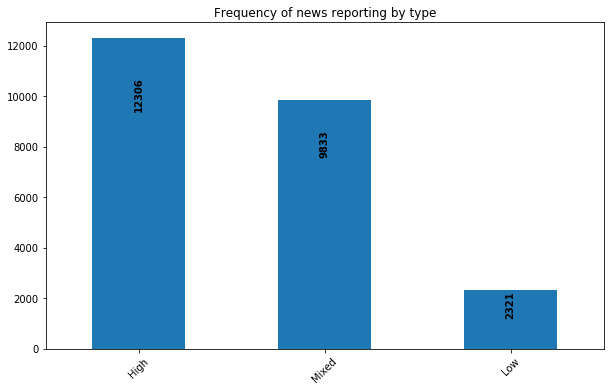

In [22]:
plt.figure(figsize=(10,6))
g = news_df_new['factual_reporting'].value_counts().plot(kind='bar',title = 'Frequency of Observations by Type')
ax=g
plt.xticks(rotation=45)


for patch in ax.patches:
    bl = patch.get_xy()
    x = 0.5 * patch.get_width() + bl[0]
    y = 0.85 * patch.get_height() + bl[1] 
    ax.text(x,y,"%d" %(patch.get_height()),
            ha='center', rotation='vertical', weight = 'bold')

ax.set_title('Frequency of news reporting by type')

### Barplot of number for facbook likes in each category

Text(0.5, 1.0, 'Facebook likes by factual reporting type')

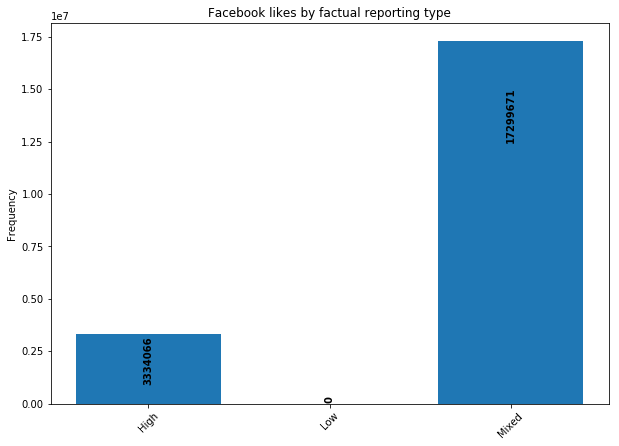

In [23]:
reporting_category = sorted(news_df_new['factual_reporting'].unique())

total_facebook_likes = []
for each_category in reporting_category:
    total_facebook_likes.append(sum(news_df_new.loc[news_df_new['factual_reporting'] == each_category]['facebook_likes']))


fig = plt.figure(figsize=(10,7))
ax=fig.gca()
plt.xticks(rotation=45)
plt.bar(reporting_category, total_facebook_likes)

for patch in ax.patches:
    bl = patch.get_xy()
    x = 0.5 * patch.get_width() + bl[0]
    y = 0.85 * patch.get_height() + bl[1] 
    ax.text(x,y,"%d" %(patch.get_height()),
            ha='center', rotation='vertical', weight = 'bold')
ax.set_ylabel('Frequency')
ax.set_title('Facebook likes by factual reporting type')


### Defining a bar_plot to see country, sites and site-type wise factuality

In [24]:
def bar_plot(values):
    
    plt.figure(figsize=(12,30))
    for i,each_value in enumerate(news_df_new['factual_reporting'].unique()):
        
        plt.subplot(6,2,i+1)
        
        g = news_df_new[values][news_df_new['factual_reporting'] == each_value].value_counts().plot(kind='bar',title = 'Frequency of Observations by Type')
        ax=g
        plt.xticks(rotation='vertical')
        if values == 'site':
            plt.subplots_adjust(wspace=0.2, hspace=2)
        else:
            plt.subplots_adjust(wspace=0.2, hspace=1)
        
        for patch in ax.patches:
            bl = patch.get_xy()
            x = 0.5 * patch.get_width() + bl[0]
            y = 0.85 * patch.get_height() + bl[1] 
            ax.text(x,y,"%d" %(patch.get_height()),
                ha='center', rotation='vertical', weight = 'bold')
        ax.set_title(values + ' wise ' +  each_value + ' factual news')


    

In [25]:
# No of articles in each site having factual report Mixed(coded to compare with bar plot)
news_df_new['site'][news_df_new['factual_reporting'] == 'Mixed'].value_counts()

edition.cnn.com                      3635
www.buzzfeed.com                     3328
us.cnn.com                           1825
www.cnn.com                           634
rss.cnn.com                           248
www.ecowatch.com                       98
www.ancient-code.com                   22
cnnpressroom.blogs.cnn.com             12
splinternews.com                       12
money.cnn.com                           6
politicaldig.com                        6
cnnespanol.cnn.com                      4
religion.blogs.cnn.com                  1
www.thenewcivilrightsmovement.com       1
cnn.com                                 1
Name: site, dtype: int64

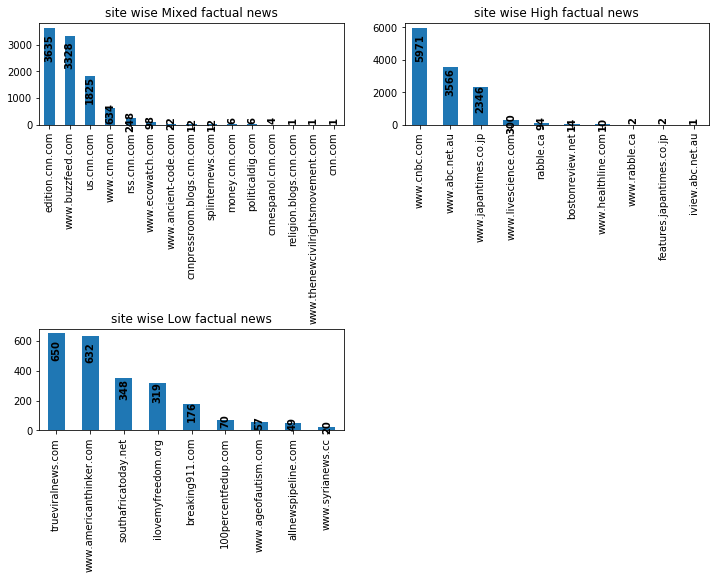

In [26]:
#calling bar_plot function to see news factuality of different sites
bar_plot('site')

In [27]:
# No of articles from each news producer country having factual report Mixed(coded to compare with bar plot)
news_df_new['country'][news_df_new['factual_reporting'] == 'Mixed'].value_counts()

United States         9682
NA                      64
Germany                 23
Tokelau                 11
Bulgaria                10
Indonesia               10
Philippines              8
European Union           7
United Kingdom(GB)       7
Turkey                   4
Japan                    3
France                   1
Liechtenstein            1
Italy                    1
Morocco                  1
Name: country, dtype: int64

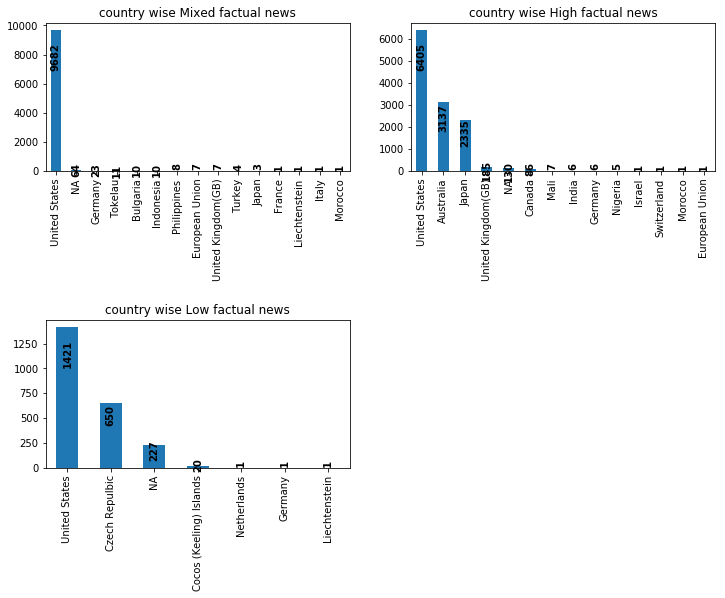

In [28]:
#calling bar_plot function to see news factuality of different news producer country
bar_plot('country')

In [115]:
# No of articles from each site type country having factual report Mixed(coded to compare with bar plot)
news_df_new.site_type[news_df_new['factual_reporting'] == 'Mixed'].value_counts()

news     7673
blogs    2160
Name: site_type, dtype: int64

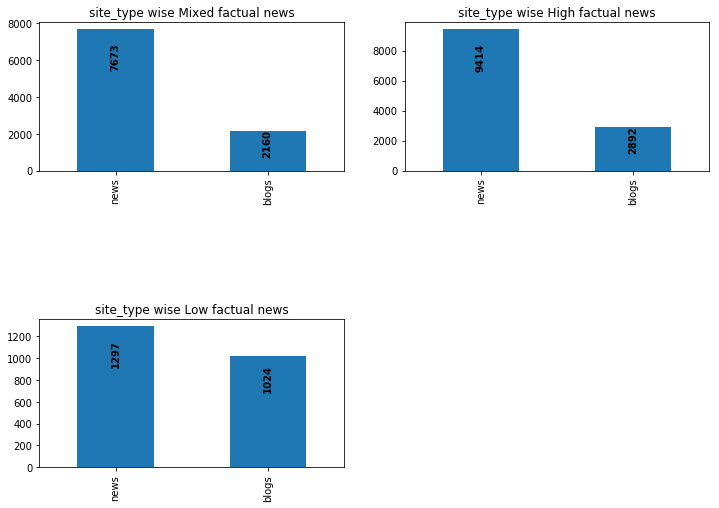

In [30]:
#calling bar_plot function to see news factuality of different site type
bar_plot('site_type')